![](https://drive.google.com/uc?export=view&id=12mnS6S9Pq9gPk1T5JVZWQAUJQ4M2U2k9)

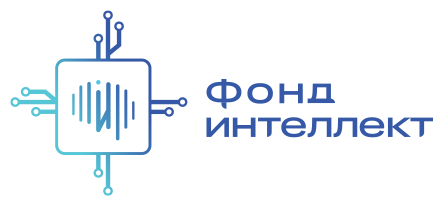

Датасеты: bulk_id.csv


Что нужно сделать?
Нужно провести полный процесс тренировки модели, включающий работу с датасетом (выбор метода векторизации и расчет соответствующих векторов), выбор оптимального алгоритма обучения (критерии могут разниться).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pymatgen ase dscribe matminer megnet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from itertools import product, repeat
from pymatgen.core import Element, Structure
from tqdm import tqdm
from matminer.utils.data import MagpieData
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore') # игнорируем предупреждения

<h4>Пример использования библиотек pymatgen и matminer для получение feature-вектора, содержащего информацию об атомных массах элементов в структуре</h4>

Вы можете использовать подобный подход, или добавить больше информации из упомянутых (или любых других) библиотек

In [ ]:
ELEMENTAL_PROPERTIES = [
    "AtomicWeight",
]


def get_magpie_properties():
    MD = MagpieData()
    all_elem_values = []

    for e in ELEMENTAL_PROPERTIES:
        elem_values = []
        for z in range(1, 93):
            elem_values.append(
                MD.get_elemental_property(Element.from_Z(z), e)
            )
        all_elem_values.append(dict(zip([str(Element.from_Z(z)) for z in range(1, 93)], elem_values)))

    return dict(zip(ELEMENTAL_PROPERTIES, all_elem_values))



def get_descriptors(structure):

    feature_vector = []
    
    for e in ELEMENTAL_PROPERTIES:
        temp_descrs = []
        for i in structure:
            temp_descrs.append(MAGPIE_PROPERTIES[e][str(i.specie)])    
        feature_vector.append((min(temp_descrs)+min(temp_descrs))/len(temp_descrs))
        feature_vector.append(min(temp_descrs))
        feature_vector.append(max(temp_descrs))
        
    return np.array(feature_vector)


MAGPIE_PROPERTIES = get_magpie_properties()

In [ ]:
"""
Тут должен быть ваш код для загрузки датасета из файла bulk_id.csv и архиве bulk_cifs.zip, содержащей структуры.

Структуры должны быть преобразованы в одномерные массивы, содержащие информацию об их химическом составе и
кристаллографической структуре.

На выходе ожидаются двухмерный массив features (признаковое описание) и
одномерный массив modulus (список значений модулей сжатия), пригодные для дальнейшего обучения моделей.

Порядок структур должен соответствовать колонке material_id в файле bulk_id.csv
"""

# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/bulk_cifs.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/")
df = pd.read_csv('/content/drive/MyDrive/bulk_prop.csv')
df.head(3)

,material_id,K_VRH
0,mp-10003,194.268884
1,mp-10010,175.449907
2,mp-10015,295.077545


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   material_id  1180 non-null   object 
 1   K_VRH        1180 non-null   float64
dtypes: float64(1), object(1)
memory usage: 18.6+ KB


In [ ]:
structures = [] # инициализируем список

for material_id in df['material_id']:
    # заполняем список объектами pymatgen.core.structure.Structure
    structures.append(Structure.from_file(f'/content/drive/MyDrive/bulk_cifs/{material_id}.cif'))

In [ ]:
X = []
y = df['K_VRH'].values

for i in range(len(structures)):
  X.append(get_descriptors(structures[i]))

#### Разобьем датасет на тренировочную и тестовую часть и воспользуемся кросс-валидацией, чтобы избежать переобучения


Для воспроизводимости результатов, не изменяйте разбиение исходной выборки, установленное ниже (посредством **random_state**).

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

scaler = MinMaxScaler() # инициализируем экземпляр класса MinMaxScaler
scaler.fit(X_train) # получаем параметры MinMaxScaler исходя из обучающей выборки
X_train = scaler.transform(X_train) # нормируем обучающую выборку
X_test = scaler.transform(X_test) # нормируем тестовую выборку

#### Натренируем выбранную вами модель

Примеры алгоритмов, которыми вы может воспользоваться (но которыми не стоит ограничиваться).

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


def get_regression_metrics(y_true, y_pred):
    metrics = {} # инициализируем словарь и рассчитываем основные регрессионные метрики
    metrics['R^2'] = round(r2_score(y_true, y_pred), 3) # коэффициент детерминации с точностью в 3 знака в дробной части
    metrics['MAE'] = round(mean_absolute_error(y_true, y_pred), 3) # MAE с точностью в 3 знака в дробной части
    metrics['RMSE'] = round(np.sqrt(mean_squared_error(y_true, y_pred)), 3) # RMSE с точностью в 3 знака пв дробной части
    return metrics # возвращаем словарь со всеми метриками

In [ ]:
model = LinearRegression() 
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

LinearRegression()
train  {'R^2': 0.034, 'MAE': 59.38, 'RMSE': 71.531}
test  {'R^2': 0.005, 'MAE': 59.549, 'RMSE': 70.351}


In [ ]:
model = Ridge(alpha=0.01)
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

Ridge(alpha=0.01)
train  {'R^2': 0.034, 'MAE': 59.38, 'RMSE': 71.531}
test  {'R^2': 0.005, 'MAE': 59.549, 'RMSE': 70.352}


In [ ]:
model = KNeighborsRegressor() 
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

KNeighborsRegressor()
train  {'R^2': 0.688, 'MAE': 29.259, 'RMSE': 40.671}
test  {'R^2': 0.521, 'MAE': 35.71, 'RMSE': 48.825}


In [ ]:
model = RandomForestRegressor() 
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

RandomForestRegressor()
train  {'R^2': 0.946, 'MAE': 12.206, 'RMSE': 16.903}
test  {'R^2': 0.71, 'MAE': 26.884, 'RMSE': 37.963}


In [ ]:
def reg_plot(y_true, y_pred, label='', units=''):
    plt.figure(figsize=(7, 7)) # задаем размер графика
    ax_min = np.min(np.hstack((y_true, y_pred))) - 0.5 # рассчитываем минимальное значение, отложенное на обеих осях
    ax_max = np.max(np.hstack((y_true, y_pred))) + 0.5 # рассчитываем максимальное значение, отложенное на обеих осях
    plt.xlim(ax_min, ax_max) # задаем диапазон значений для оси абсцисс
    plt.ylim(ax_min, ax_max) # задаем диапазон значений для оси ординат
    plt.scatter(y_true, y_pred, marker='*') # наносим на график точки с координатами (y_true_i, y_pred_i)
    plt.plot([ax_min, ax_max], [ax_min, ax_max], color='k', linestyle='-.') # штрихпунктирная линия x=y
    plt.xlabel(f'{label} calculated, [{units}]') # подпись к оси абсцисс
    plt.ylabel(f'{label} predicted, [{units}]') # подпись к оси ординат
    plt.gca().set_aspect('equal', adjustable='box') # задаём равный масштаб по оси абсцисс и ординат

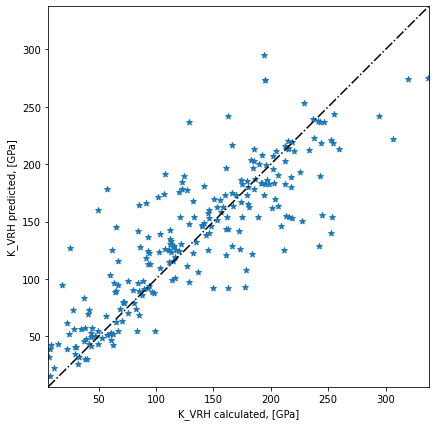

In [ ]:
reg_plot(y_test, model.predict(X_test), label='K_VRH', units='GPa')

In [ ]:
from matminer.featurizers.structure.bonding import BagofBonds
from matminer.featurizers.structure.matrix import CoulombMatrix

featurizer = BagofBonds(coulomb_matrix=CoulombMatrix(flatten=False)) # инициализируем bag of bonds
featurizer.fit(structures) # формируем bag of bonds
X = np.array(featurizer.featurize_many(structures)) # рассчитываем bag of bonds для каждой структуры

BagofBonds:   0%|          | 0/1180 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

scaler = MinMaxScaler() # инициализируем экземпляр класса MinMaxScaler
scaler.fit(X_train) # получаем параметры MinMaxScaler исходя из обучающей выборки
X_train = scaler.transform(X_train) # нормируем обучающую выборку
X_test = scaler.transform(X_test) # нормируем тестовую выборку

selector = VarianceThreshold(threshold=1e-2) # инициализируем экземпляр класса VarianceThreshold
selector.fit(X_train) # расчёт дисперсии признаков на обучающей выборке
X_train = selector.transform(X_train) # отсев признаков с низкой дисперсией для объектов из обучающей выборки
X_test = selector.transform(X_test) # отсев признаков с низкой дисперсией для объектов из тестовой выборки

model = RandomForestRegressor()
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

RandomForestRegressor()
train  {'R^2': 0.929, 'MAE': 11.459, 'RMSE': 19.381}
test  {'R^2': 0.679, 'MAE': 27.628, 'RMSE': 39.976}


In [ ]:
model = KNeighborsRegressor() 
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

KNeighborsRegressor()
train  {'R^2': 0.684, 'MAE': 26.913, 'RMSE': 40.939}
test  {'R^2': 0.549, 'MAE': 34.415, 'RMSE': 47.354}


In [ ]:
model = Ridge(alpha=0.01)
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

Ridge(alpha=0.01)
train  {'R^2': 0.843, 'MAE': 18.367, 'RMSE': 28.824}
test  {'R^2': 0.571, 'MAE': 32.688, 'RMSE': 46.197}


In [ ]:
from pymatgen.core import Element
from matminer.featurizers.composition.element import ElementFraction
from megnet.data.crystal import get_elemental_embeddings

featurizer = ElementFraction() # инициализируем экземпляр класса ElementFraction
compositions = [s.composition for s in structures]
X = np.array(featurizer.featurize_many(compositions))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

scaler = MinMaxScaler() # инициализируем экземпляр класса MinMaxScaler
scaler.fit(X_train) # получаем параметры MinMaxScaler исходя из обучающей выборки
X_train = scaler.transform(X_train) # нормируем обучающую выборку
X_test = scaler.transform(X_test) # нормируем тестовую выборку

model = RandomForestRegressor() 
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

ElementFraction:   0%|          | 0/1180 [00:00<?, ?it/s]

RandomForestRegressor()
train  {'R^2': 0.976, 'MAE': 7.243, 'RMSE': 11.363}
test  {'R^2': 0.85, 'MAE': 18.01, 'RMSE': 27.341}


In [ ]:
model = KNeighborsRegressor() 
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

KNeighborsRegressor()
train  {'R^2': 0.863, 'MAE': 18.336, 'RMSE': 26.952}
test  {'R^2': 0.75, 'MAE': 24.089, 'RMSE': 35.266}


In [ ]:
model = Ridge(alpha=0.01)
model.fit(X_train, y_train)
print(model)
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))

Ridge(alpha=0.01)
train  {'R^2': 0.902, 'MAE': 15.752, 'RMSE': 22.821}
test  {'R^2': 0.835, 'MAE': 18.649, 'RMSE': 28.606}


In [ ]:
from megnet.utils.models import load_model
model = load_model("logK_MP_2018")

INFO:megnet.utils.models:Package-level mvl_models not included, trying temperary mvl_models downloads..
INFO:megnet.utils.models:Model found in local mvl_models path


In [ ]:
y_pred = []
for i in range(291, 909):
  # print(i)
  y_pred.append(10 ** model.predict_structure(structures[i]))

In [ ]:
get_regression_metrics(y[291:909], y_pred)

{'MAE': 2.885, 'RMSE': 5.05, 'R^2': 0.995}

In [ ]:
import tensorflow as tf
dim_input = X.shape[1]

# Формирование модели
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(dim_input, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'), 
  tf.keras.layers.Dense(124, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_absolute_error',
                optimizer='sgd')


In [ ]:
model.fit(X_train, y_train, epochs=150)

Epoch 1/150
30/30 [==============================] - 7s 51ms/step - loss: 136.4394
Epoch 2/150
30/30 [==============================] - 0s 4ms/step - loss: 135.0422
Epoch 3/150
30/30 [==============================] - 0s 4ms/step - loss: 128.4627
Epoch 4/150
30/30 [==============================] - 0s 5ms/step - loss: 68.0605
Epoch 5/150
30/30 [==============================] - 0s 4ms/step - loss: 52.9609
Epoch 6/150
30/30 [==============================] - 0s 5ms/step - loss: 42.9765
Epoch 7/150
30/30 [==============================] - 1s 20ms/step - loss: 37.6923
Epoch 8/150
30/30 [==============================] - 0s 11ms/step - loss: 35.3033
Epoch 9/150
30/30 [==============================] - 0s 16ms/step - loss: 34.3652
Epoch 10/150
30/30 [==============================] - 0s 3ms/step - loss: 31.9851
Epoch 11/150
30/30 [==============================] - 0s 3ms/step - loss: 33.7540
Epoch 12/150
30/30 [==============================] - 0s 3ms/step - loss: 31.4087
Epoch 13/150
30/30

train  {'R^2': 0.957, 'MAE': 10.869, 'RMSE': 15.044}
test  {'R^2': 0.89, 'MAE': 14.977, 'RMSE': 23.422}


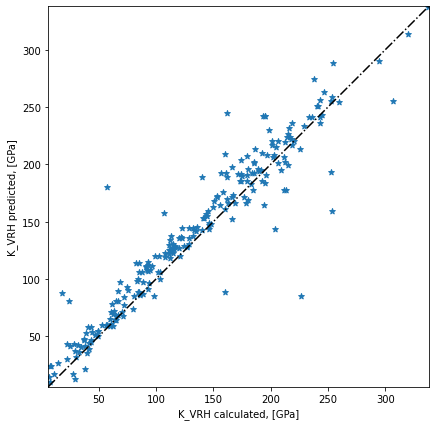

In [ ]:
print('train ', get_regression_metrics(y_train, model.predict(X_train)))
print('test ', get_regression_metrics(y_test, model.predict(X_test)))
y_pred = model.predict(X_test)
reg_plot(y_test, y_pred.flatten(), label='K_VRH', units='GPa')